# Selecting admixed individuals 

- **Goal**: subsetting a set of individuals that are admixed from a set of reference populations. This can be useful for subsequent analyses that focus on admixed individuals, e.g., local ancestry inference.
- **Input**: principal components jointly calculated from the your data sets and a reference populations (e.g., 1,000 Genomes project).
- **Output**: scores for each individual evaluating the distance to the reference populations.

In [1]:
import admix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from admix.data import distance_to_line, distance_to_refpop

## Simulating the data
First, we simulate the top 2 PCs for ancestral population 1 and 2, and some sample data. Our goal is to select a subset of admixed individuals from ancestral population 1 and 2 within the sample data for subsequent analysis.

For population 1, we simulate:

$\text{PC}^{(1)} \sim \mathcal{N} \left( \begin{bmatrix} -5 \\ -5 \end{bmatrix}, \begin{bmatrix} 1/4 & 0 \\ 0 & 1/4 \end{bmatrix} \right)$

For population 2, we simulate:

$\text{PC}^{(2)} \sim \mathcal{N} \left( \begin{bmatrix} 5 \\ 5 \end{bmatrix}, \begin{bmatrix} 4 & 0 \\ 0 & 4 \end{bmatrix} \right)$

For sample individuals, we simulate:

$\text{PC}^{(s)} \sim \mathcal{N} \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 10 & 10/3 \\ 10/3 & 10 \end{bmatrix} \right)$


In [2]:
# simulate 2 ancestral populations
np.random.seed(0)
# number of individuals in ancestral populations
n_anc = 50
# number of individuals in the sample
n_sample = 30
anc1_pc = np.random.multivariate_normal(
    mean=[-5, -5], cov=np.array([[1 / 4, 0], [0, 1 / 4]]), size=n_anc
)
anc2_pc = np.random.multivariate_normal(
    mean=[5, 5], cov=np.array([[4, 0], [0, 4]]), size=n_anc
)
sample_pc = np.random.multivariate_normal(
    mean=[0, 0], cov=np.array([[1, 1 / 3], [1 / 3, 1]]) * 10, size=n_sample
)

# template function to plot the data
def plot_data(ax):
    """
    Plot the data on the given axis
    """
    ax.scatter(anc1_pc[:, 0], anc1_pc[:, 1], color="blue", label="Ancestry 1", s=2)
    ax.scatter(anc2_pc[:, 0], anc2_pc[:, 1], color="red", label="Ancestry 2", s=2)
    ax.scatter(sample_pc[:, 0], sample_pc[:, 1], color="orange", label="Sample", s=2)
    ax.legend(ncol=3, loc="center", bbox_to_anchor=[0.5, 1.05], fontsize=8)
    ax.set_aspect("equal")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

## Visualization of the simulated data

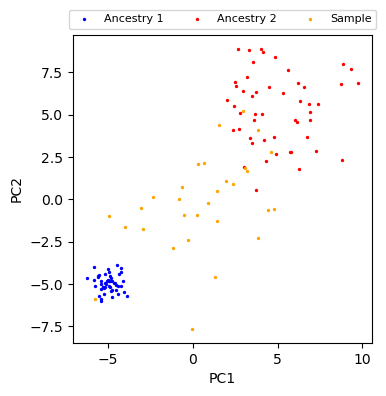

In [3]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_data(ax)
plt.show()

## Projection distance from sample PCs to connecting line between ancestral populations
We provide a function `distance_to_line`, which calculates the projection distance of each point to the line connecting the center of two ancestral populations 
$\mu^{(1)} = \overline{\text{PC}^{(1)}}, \mu^{(2)} = \overline{\text{PC}^{(2)}}$.

In [4]:
print(distance_to_line.__doc__)


    Calculate the distance of each row of a matrix to a reference line

    https://stackoverflow.com/questions/50727961/shortest-distance-between-a-point-and-a-line-in-3-d-space

    Parameters
    ----------
    p: np.ndarray
        matrix (n_indiv, n_var)
    a: np.ndarray
        ref point 1
    b: np.ndarray
        ref point 2
    weight: np.ndarray, optional
        weight associated to each dimension, for example, could be sqrt(eigenvalues)
        if not provided, equal weights for each coordinate will be used

    Returns
    -------
    dist: np.ndarray
        vector distance to the line
    t: np.ndarray
        projected length on the line, normalized according to the length of (b - a)
        t = 0 corresponds projection to a; t = 1 corresponds projection to b.
    n: np.ndarray
        normal vector from the projection point to the original point
        t*b + (1 - t)*a + n can be used to reconstruct the point position.
    


In [5]:
# center of PC in ancestral populations
anc1_mean = anc1_pc.mean(axis=0)
anc2_mean = anc2_pc.mean(axis=0)
samples_dists, sample_ts, sample_ns = distance_to_line(sample_pc, anc1_mean, anc2_mean)

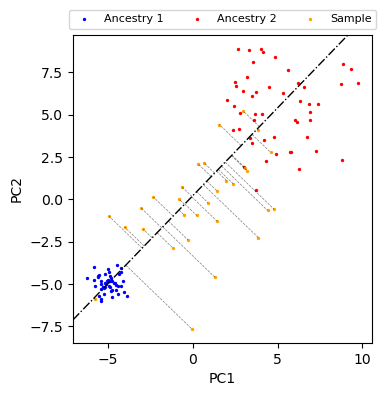

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_data(ax)

ax.axline(xy1=anc1_mean, xy2=anc2_mean, color="black", lw=1, ls="-.")

# plot the normal vector
for t, n in zip(sample_ts, sample_ns):
    p1 = t * anc2_mean + (1 - t) * anc1_mean
    p2 = p1 + n
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color="black", ls="--", lw=0.5, alpha=0.5)
plt.show()

## Accounting for different variance of ancestral populations

In [7]:
anc1_dists, anc1_ts, anc1_ns = distance_to_line(anc1_pc, anc1_mean, anc2_mean)
anc2_dists, anc2_ts, anc2_ns = distance_to_line(anc2_pc, anc1_mean, anc2_mean)
scale = 1.0
anc1_maxdist, anc2_maxdist = np.max(anc1_dists), np.max(anc2_dists)
anc1_maxdist, anc2_maxdist = anc1_maxdist * scale, anc2_maxdist * scale
normal_vec = sample_ns[0] / np.linalg.norm(sample_ns[0])

fill_pts = np.array(
    [
        anc1_mean + normal_vec * anc1_maxdist,
        anc2_mean + normal_vec * anc2_maxdist,
        anc2_mean - normal_vec * anc2_maxdist,
        anc1_mean - normal_vec * anc1_maxdist,
    ]
)

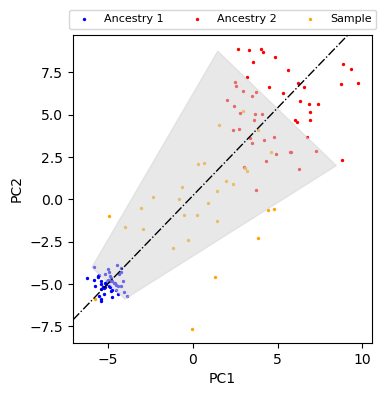

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_data(ax)
ax.axline(xy1=anc1_mean, xy2=anc2_mean, color="black", lw=1, ls="-.")
ax.fill(fill_pts[:, 0], fill_pts[:, 1], color="lightgray", alpha=0.5)
plt.show()

## Transforming the coordinates

In [9]:
print(distance_to_refpop.__doc__)


    Calculate the projection distance and position for every sample individuals to the
    line defined by two ancestry populations.

    Parameters
    ----------
    sample: np.ndarray
        (n_indiv, n_dim) matrix
    anc1: np.ndarray
        (n_indiv, n_dim) matrix
    anc2: np.ndarray
        (n_indiv, n_dim) matrix
    weight: np.ndarray, optional
        weight associated to each dimension, for example, could be sqrt(eigenvalues)
        if each dimension corresponds to a principal components.
        if not provided, equal weights for each dimension will be used

    Returns
    -------
    dist: np.ndarray
        normalized distance to the line defined by two ancestral populations
    t: np.ndarray
        projection position
    


In [10]:
anc1_dist, anc1_t = distance_to_refpop(anc1_pc, anc1_pc, anc2_pc)
anc2_dist, anc2_t = distance_to_refpop(anc2_pc, anc1_pc, anc2_pc)
sample_dist, sample_t = distance_to_refpop(sample_pc, anc1_pc, anc2_pc)

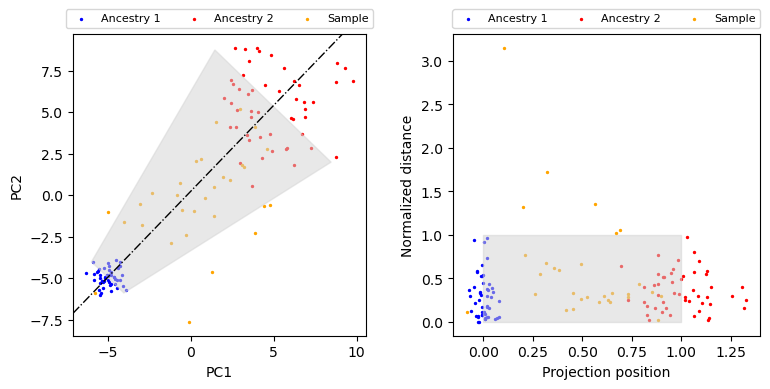

In [11]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
ax = axes[0]
plot_data(ax)
ax.axline(xy1=anc1_mean, xy2=anc2_mean, color="black", lw=1, ls="-.")
ax.fill(fill_pts[:, 0], fill_pts[:, 1], color="lightgray", alpha=0.5)

ax = axes[1]
ax.scatter(anc1_t, anc1_dist, color="blue", label="Ancestry 1", s=2)
ax.scatter(anc2_t, anc2_dist, color="red", label="Ancestry 2", s=2)
ax.scatter(sample_t, sample_dist, color="orange", label="Sample", s=2)
ax.legend(ncol=3, loc="center", bbox_to_anchor=[0.5, 1.05], fontsize=8)
ax.fill_between([0, 1], 1, color="lightgray", alpha=0.5)
ax.set_xlabel("Projection position")
ax.set_ylabel("Normalized distance")

fig.tight_layout()

## Puttings things together

In [12]:
# prepare sample_pc, anc1_pc, anc2_pc
sample_dist, sample_t = distance_to_refpop(sample_pc, anc1_pc, anc2_pc)

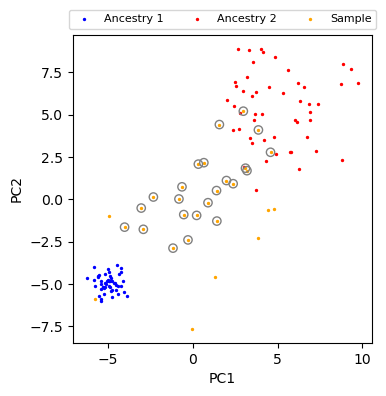

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

# t between 0.1 and 0.9, dist < 1.0
plot_data(ax)
mask = (0.1 < sample_t) & (sample_t < 0.9) & (sample_dist < 1.0)
ax.scatter(sample_pc[mask, 0], sample_pc[mask, 1], facecolors="none", edgecolors="gray")
plt.show()

In [14]:
# helper function
def plot_selection(t1, t2, dist, ax):
    plot_data(ax)
    mask = (t1 < sample_t) & (sample_t < t2) & (sample_dist < dist)
    ax.scatter(
        sample_pc[mask, 0],
        sample_pc[mask, 1],
        facecolors="none",
        edgecolors="black",
        s=15,
    )
    ax.set_title(
        f"$t \\in [{t1 * 100:.0f}\%, {t2 * 100:.0f}\%] & (dist < {dist})$",
        y=1.1,
        fontsize=10,
    )

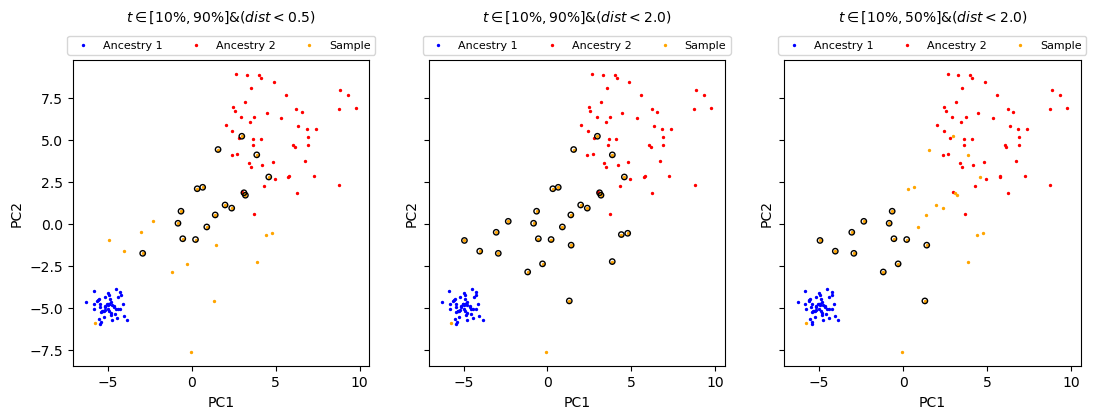

In [15]:
fig, axes = plt.subplots(figsize=(13, 4), ncols=3, sharey=True, sharex=True)

# more stringent
plot_selection(0.1, 0.9, 0.5, axes[0])
# less stringent
plot_selection(0.1, 0.9, 2.0, axes[1])
# closer to ancestry 1
plot_selection(0.1, 0.5, 2.0, axes[2])
plt.show()